<a href="https://colab.research.google.com/github/FilippMaksimov/Net.FeaturesAndModels/blob/main/Models_Maksimov_F_Lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('glass.csv')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [ ]:
# Проверка количества записей для каждого класса
class_counts = data['Type'].value_counts()
print(class_counts)

#Классы 1 и 2 представлены значительно больше, что может повлиять на обучение модели

Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Разделение данных
X = data.drop('Type', axis=1)
y = data['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Обучение модели дерева решений
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#Точность предсказания модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность: {accuracy * 100:.2f} %')

Точность: 83.72 %


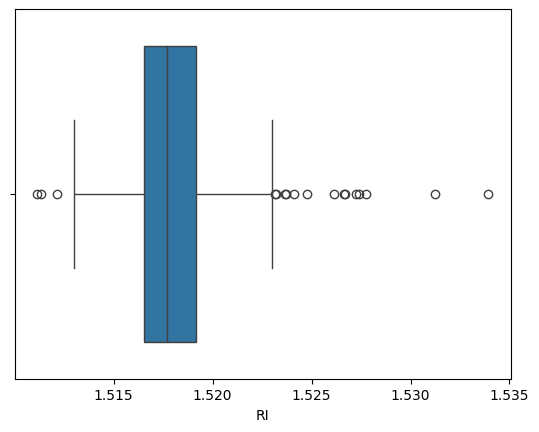

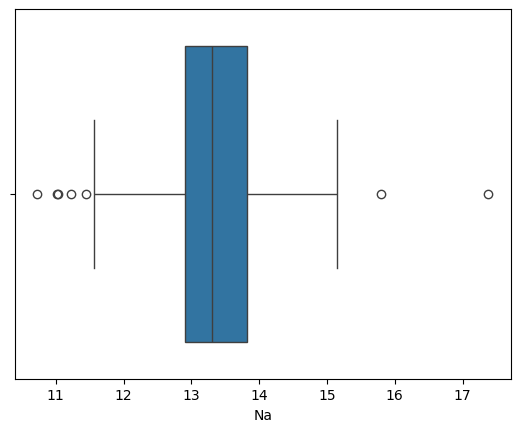

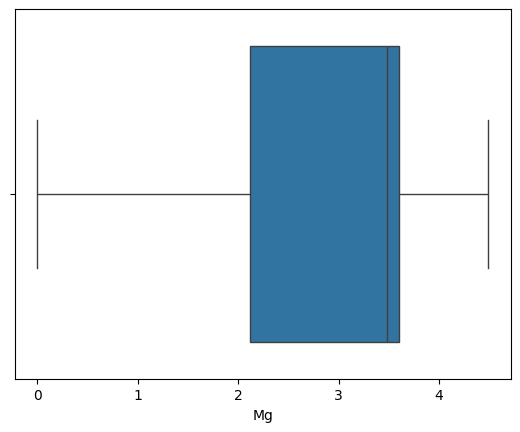

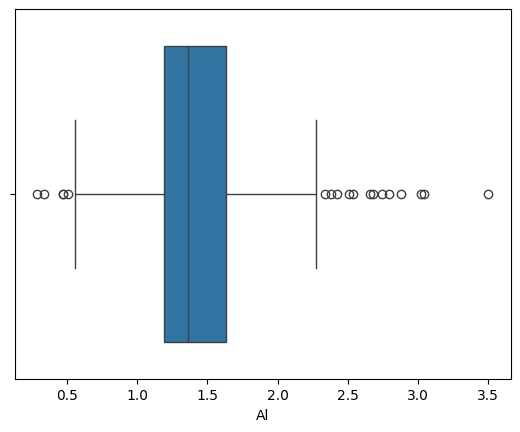

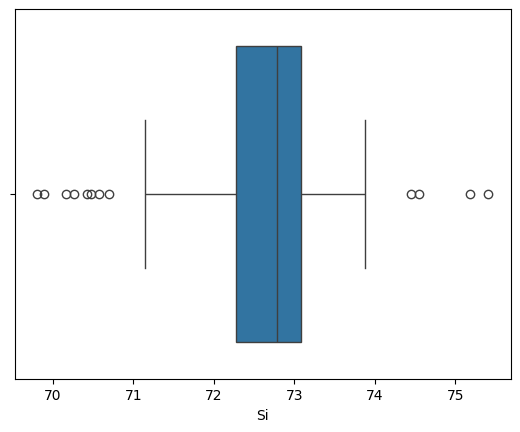

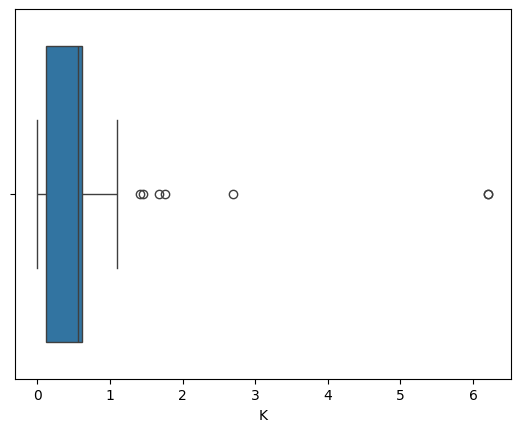

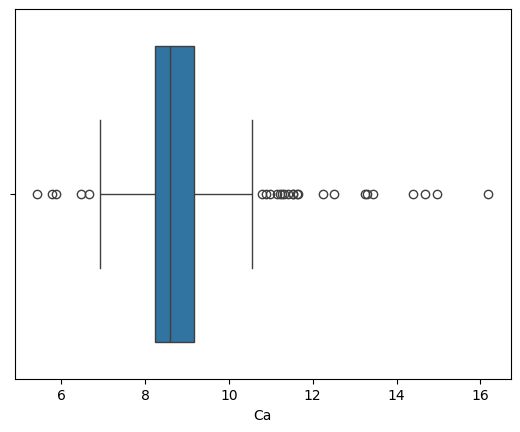

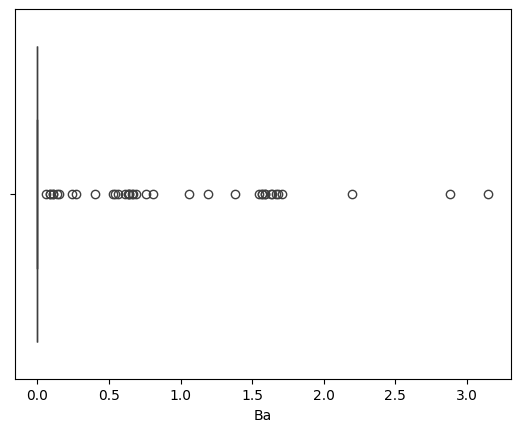

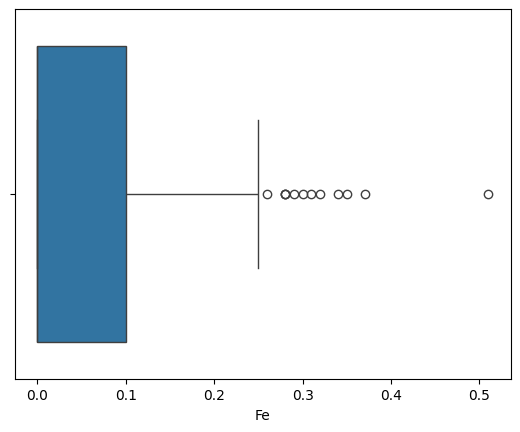

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Визуализация распределения значений
for column in X.columns:
    sns.boxplot(x=X[column])
    plt.show()

array([[<Axes: title={'center': 'RI'}>, <Axes: title={'center': 'Na'}>,
        <Axes: title={'center': 'Mg'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Si'}>,
        <Axes: title={'center': 'K'}>],
       [<Axes: title={'center': 'Ca'}>, <Axes: title={'center': 'Ba'}>,
        <Axes: title={'center': 'Fe'}>]], dtype=object)

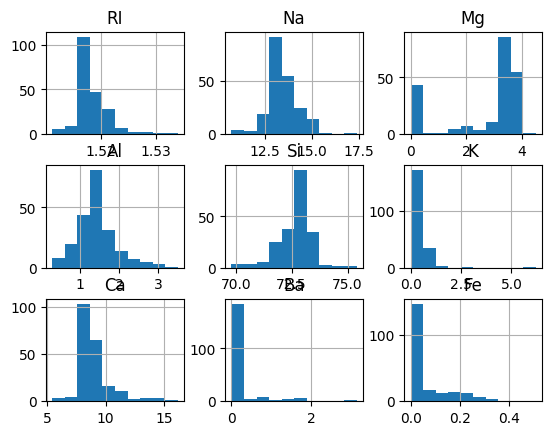

In [ ]:
#Можем наблюдать, что Rl, Na, Al, Si, Ca имеют нормальные распределения
X.hist()

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

classifiers = {
    "OCSVM": OneClassSVM(nu=0.1),
    "IsoForest": IsolationForest(),
    "ELL": EllipticEnvelope(contamination=0.2),
}

outliers_results = {}
for name, model in classifiers.items():
    outliers_results[name] = model.fit_predict(X_scaled) == -1

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-30.321784736518314 > -94.468356984934815). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-30.186316292538724 > -94.432791098325666). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-30.308556734229878 > -94.441495837641938). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
/usr/local/lib/p

In [ ]:
# Выбор конкретного столбца для визуализации
def visualize_outliers(feature_index = X.columns.get_loc('Na')):
  plt.figure(figsize=(14, 10))
  colors = ['m', 'g', 'b', 'y']
  models = list(classifiers.keys())

  for i, (name, outliers) in enumerate(outliers_results.items()):
      plt.subplot(2, 2, i + 1)
      plt.title(name)

      # Визуализация нормальных точек по выбранному столбцу
      plt.scatter(X_scaled[~outliers, feature_index], np.arange(len(X_scaled[~outliers])), s=20, color=colors[i], label='Normal', alpha=0.6)
      # Визуализация выбросов по выбранному столбцу
      plt.scatter(X_scaled[outliers, feature_index], np.arange(len(X_scaled[outliers])), s=50, edgecolor='k', facecolor='none', label='Outlier')

      plt.xlabel(f'Значение {X.columns[feature_index]}')
      plt.ylabel('Индекс')
      plt.legend()
      plt.grid()

  plt.tight_layout()
  plt.show()

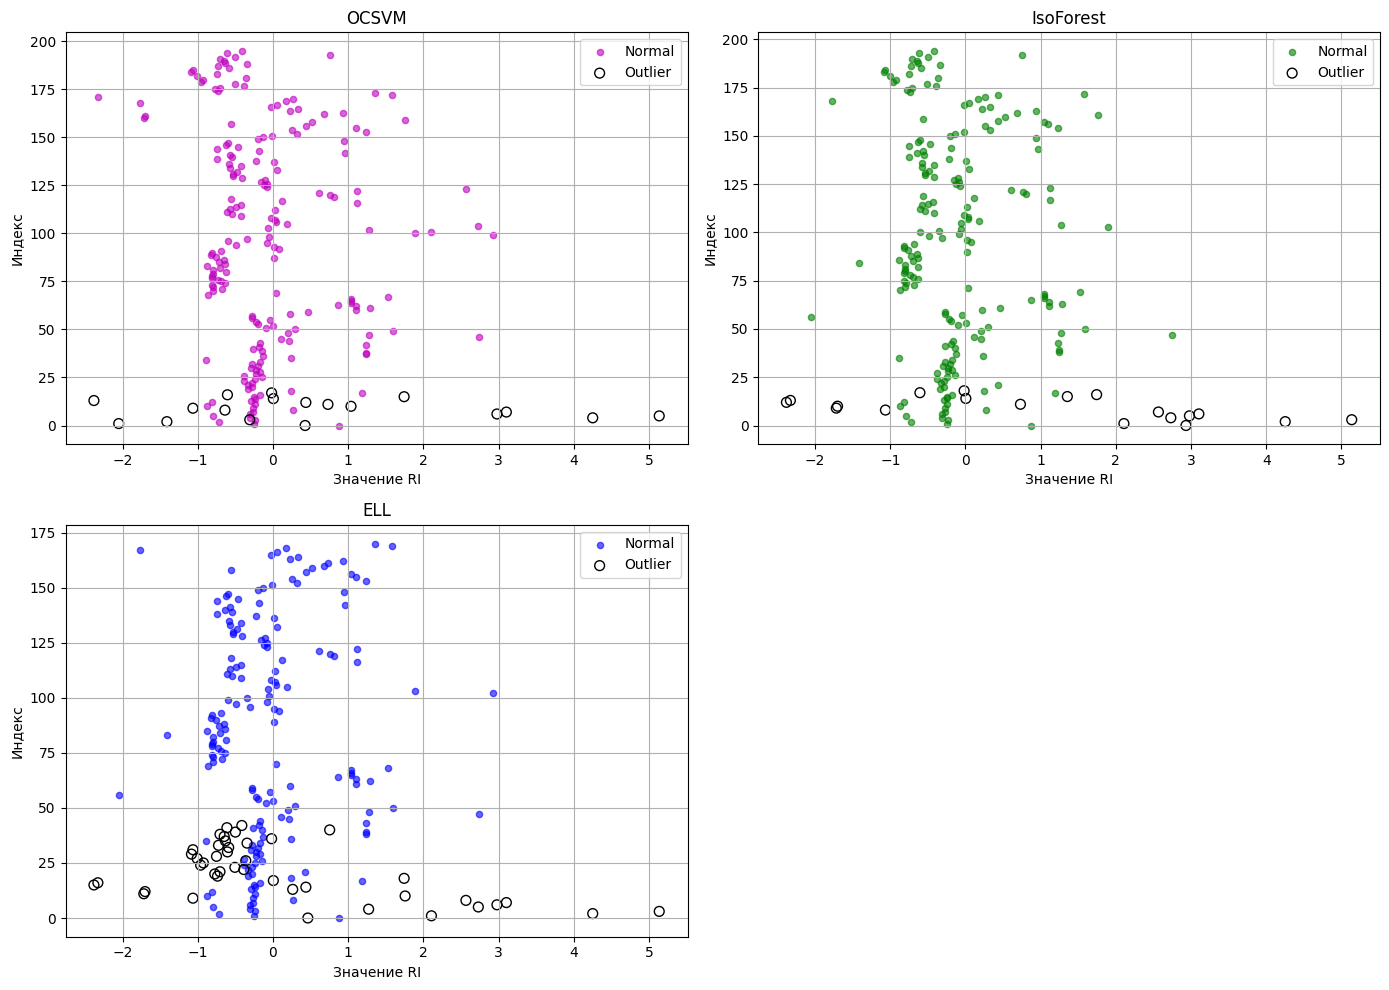

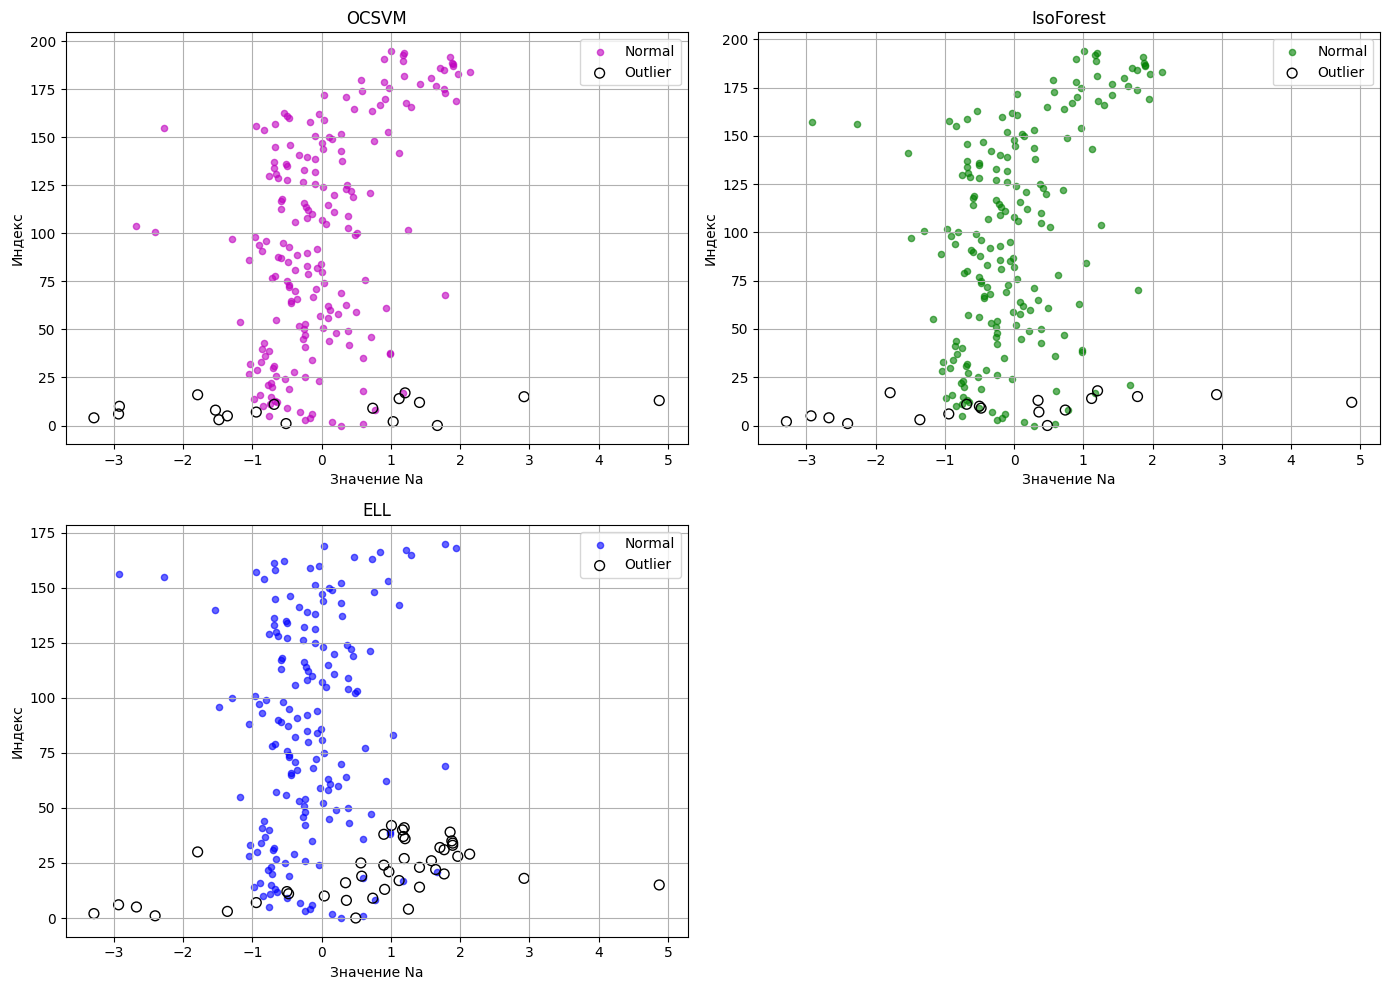

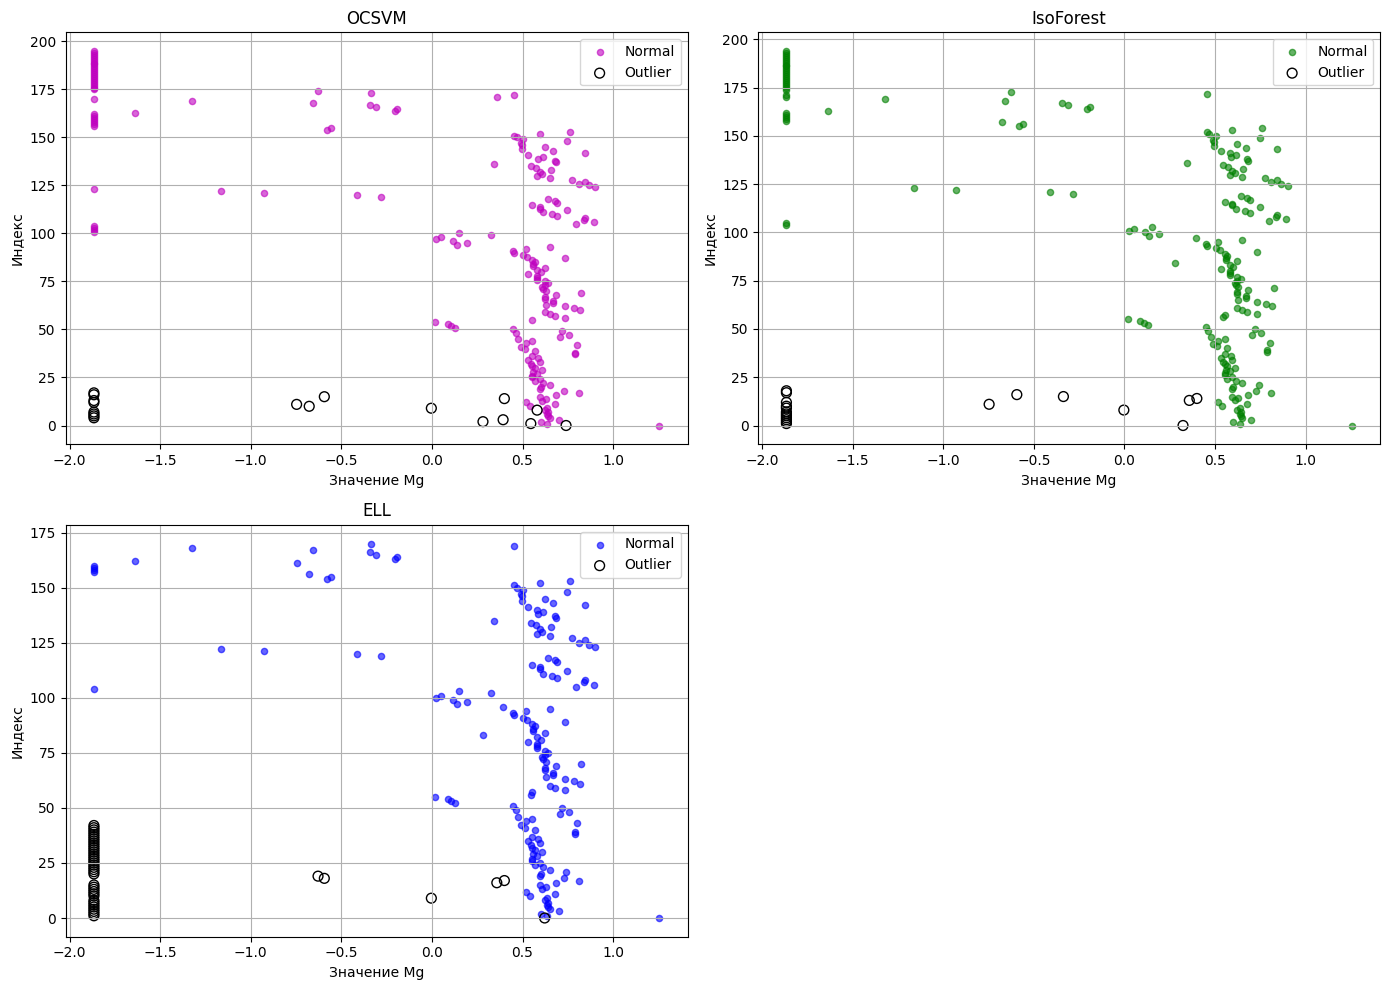

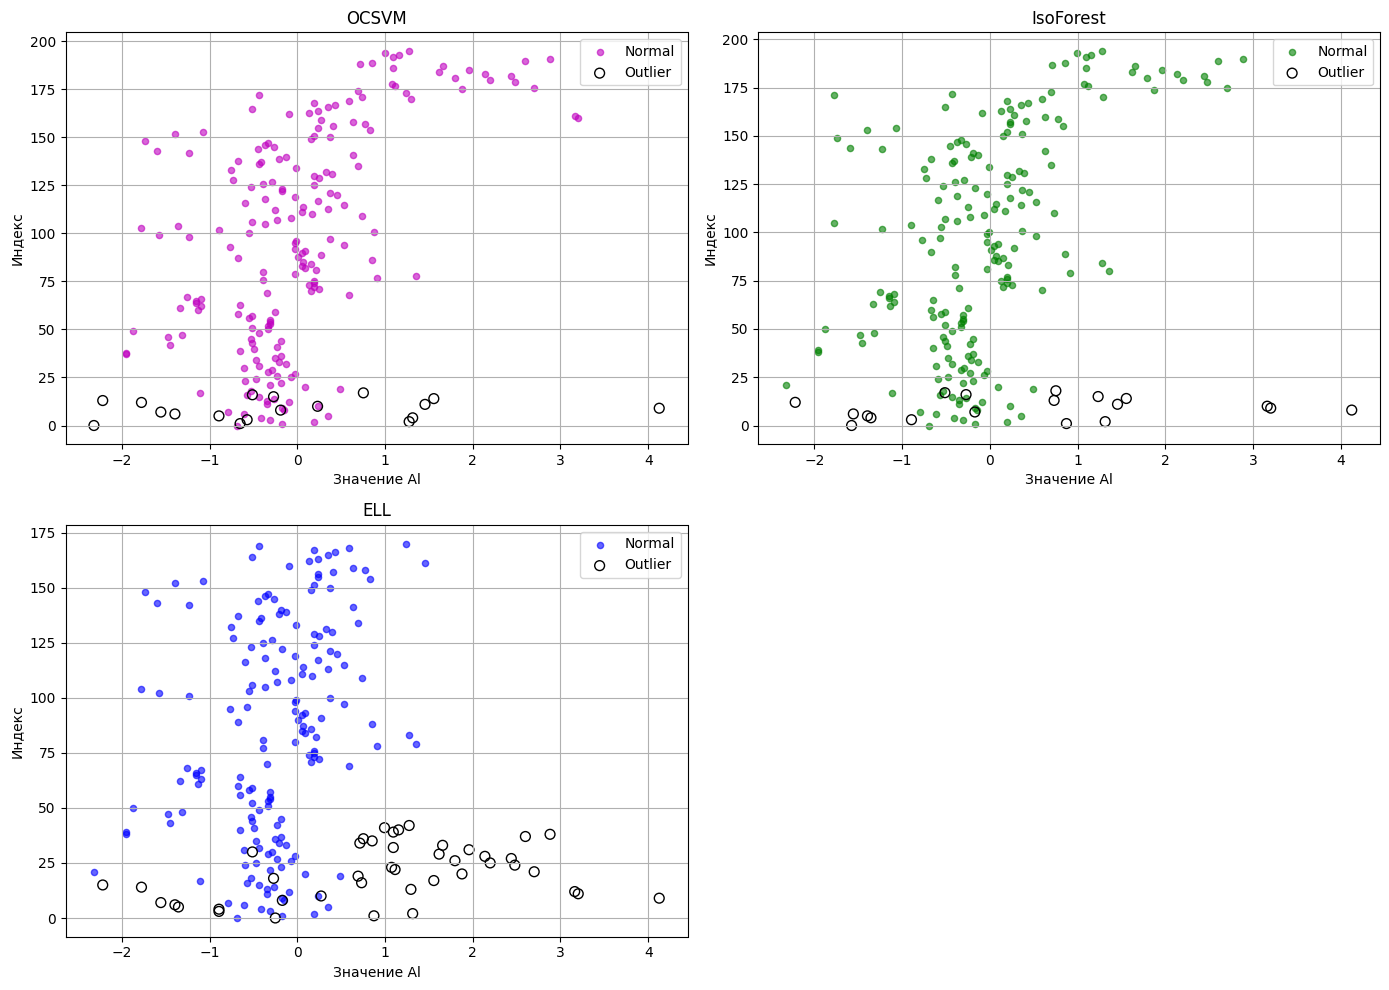

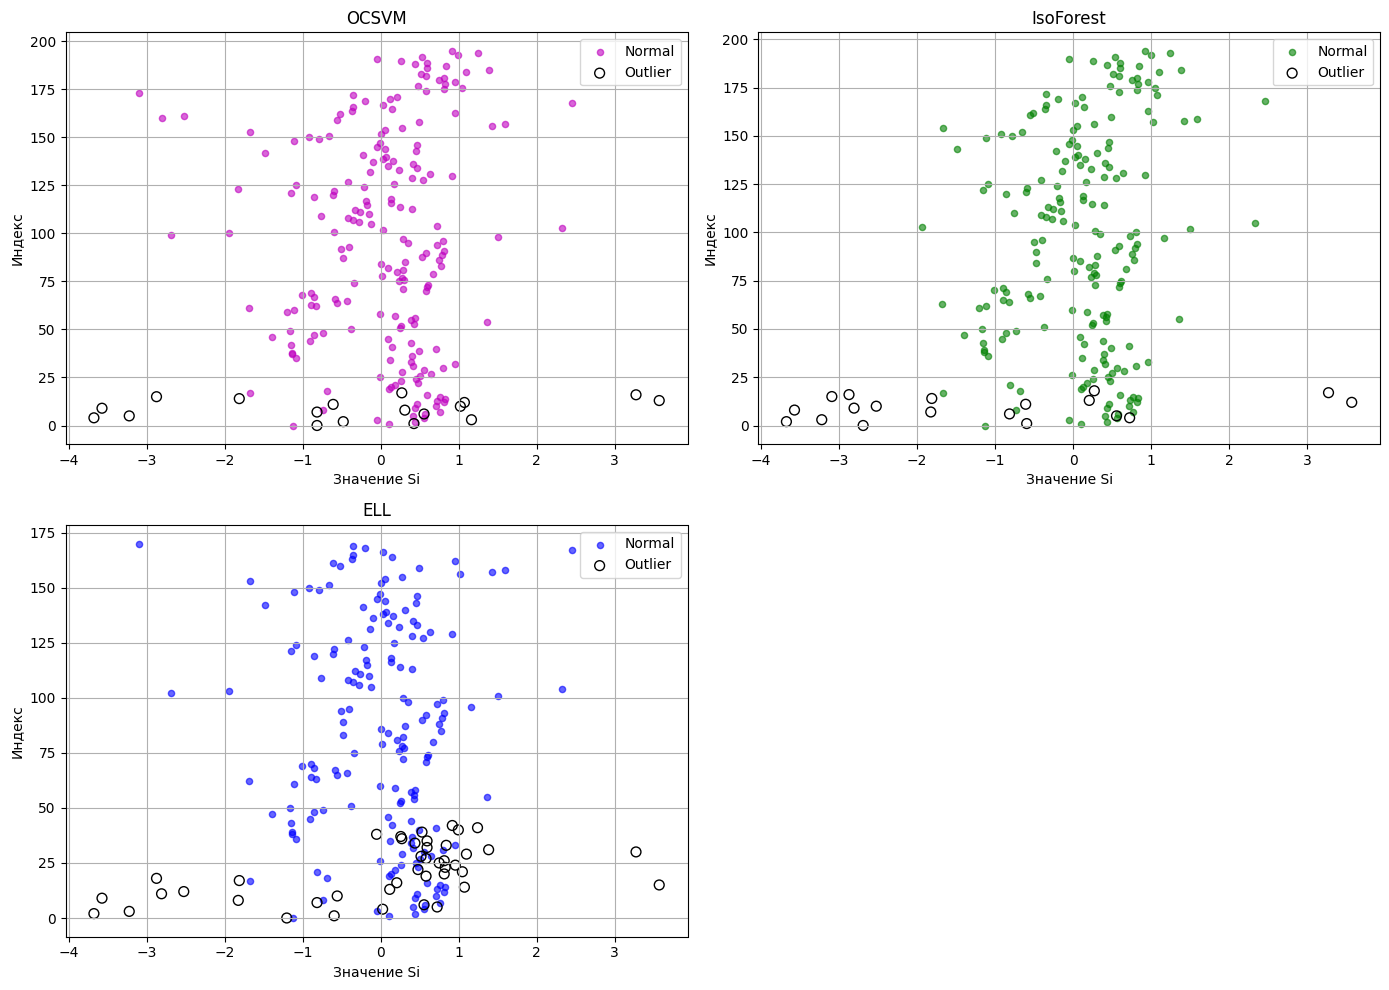

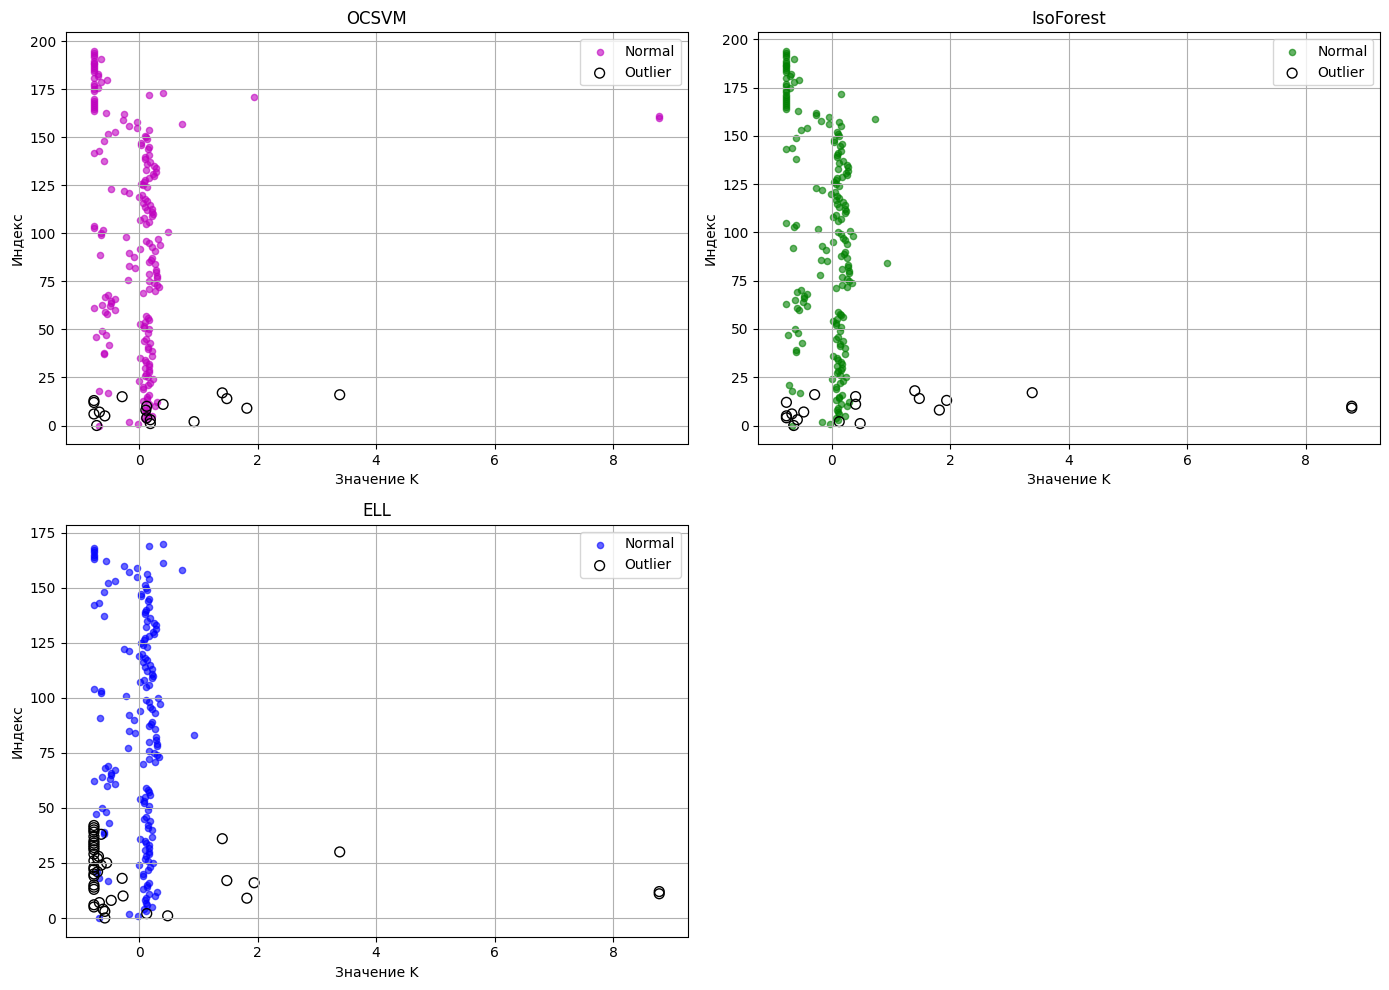

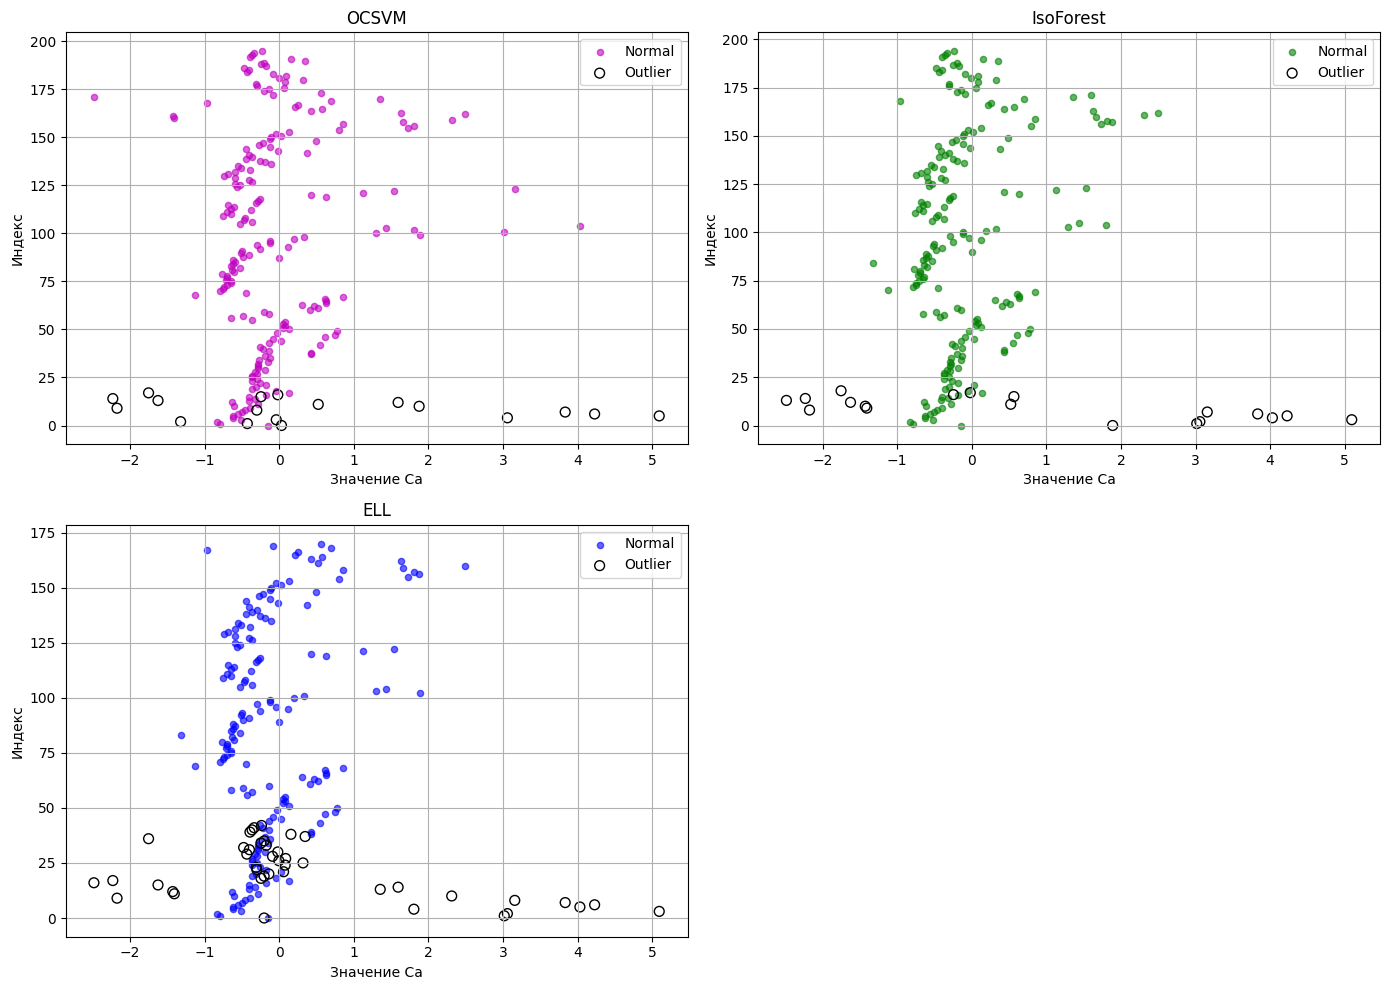

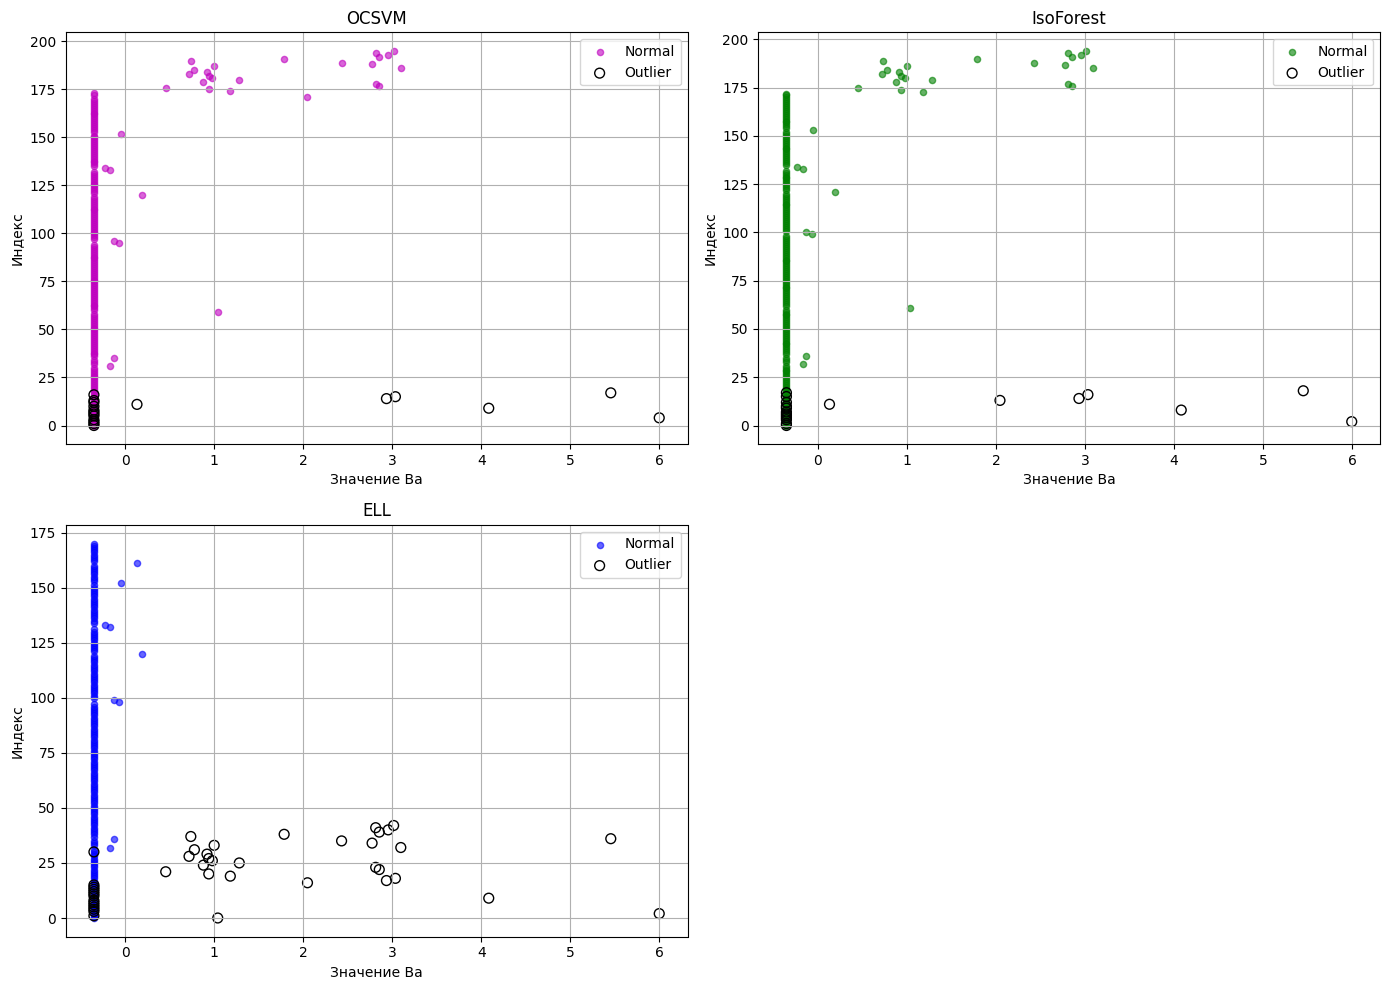

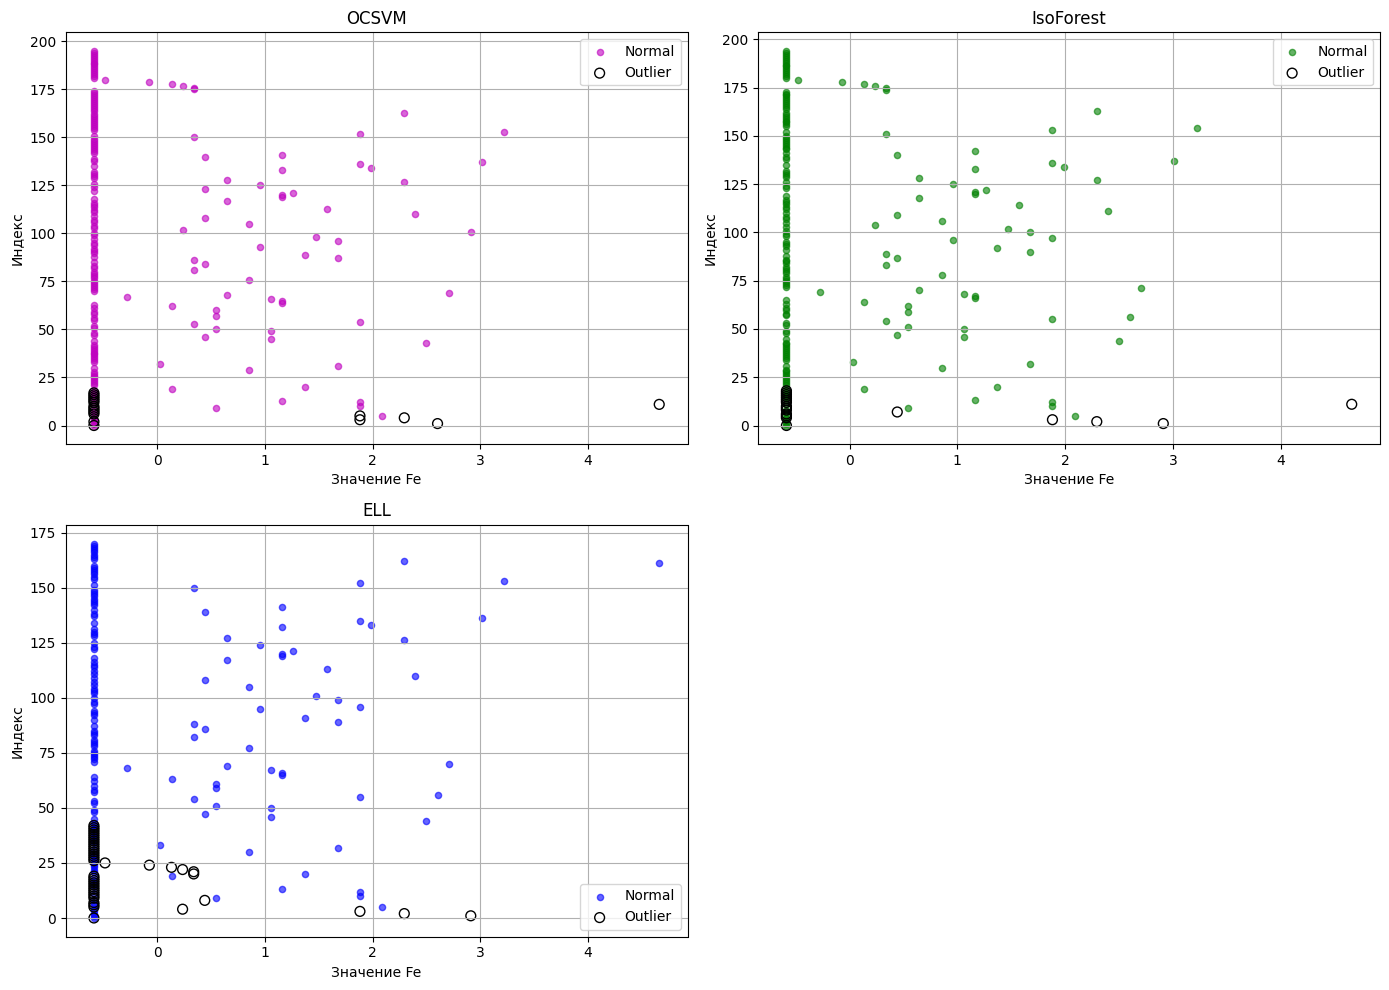

In [ ]:
for i in range(len(X.columns)):
  visualize_outliers(i)

Удалим выбросы

In [ ]:
# Пример удаления выбросов с использованием IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Создание булевой маски для выбросов
outlier_mask = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))
# Сохранение индексов нормальных данных
data_cleaned = data[~outlier_mask.any(axis=1)]

removed_percentage = 100 * (len(data) - len(data_cleaned)) / len(data)
print(f'Процент удаленных записей: {removed_percentage:.2f}%')

Процент удаленных записей: 36.45%


In [ ]:
X = data_cleaned.drop('Type', axis=1)
y = data_cleaned['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
#Точность после очистки выбросов
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность: {accuracy * 100:.2f} %')

Точность: 75.00 %
